In [1]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
import pickle 
from src import util_analysis 

In [2]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_3")
fig_out_dir.mkdir(exist_ok=True, parents=True)

In [3]:
### Byrne et al. 2023 data 

byrne_data = np.array([-0.09484242924828479, 0.4982925897160886,
                        5.013827763189802, -3.951329561004476,
                        10.05543433148005, -10.226709567661526,
                        19.95734556258245, -13.644653196411767,
                        39.96515321490358, -15.760526975438765,
                        0.022518913010429742, -11.306631162395057,
                        5.0401272236399315, -11.078483342990165,
                        10.065132257521036, -12.854847524768747,
                        19.96030425188309, -14.446457996885155,
                        39.8901997526207, -15.448138696779548]).reshape(-1, 2)
                        
byrne_data = pd.DataFrame({'distractor_azim':byrne_data[:,0], 'threshold_snr':byrne_data[:,1]})
byrne_data['dist_type'] = ["speech"] * 5 + ["noise"] * 5 
byrne_data['distractor_azim'] = byrne_data['distractor_azim'].astype(int).abs()



## Model data 

grouped_results = pd.read_csv("final_results_to_share/experiment_4_results.csv")

In [4]:
outfig_dest = Path('final_figures')
outfig_dest.mkdir(parents=True, exist_ok=True)

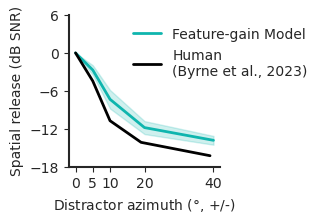

In [5]:


human_str = "Human\n(Byrne et al., 2023)"

model_to_plot = grouped_results[grouped_results.model.str.contains('Feature') & grouped_results.sex_cond.str.contains('same')].copy() # already filtered for wanted data 
model_to_plot['distractor_azim'] = model_to_plot['distractor_azim'].astype(int).abs()
model_to_plot = model_to_plot[model_to_plot.distractor_azim <= 40]

# get threshold for each target azimuth and dist_type
model_thresholds = []
for (model, azim), group in model_to_plot.groupby(['model', 'distractor_azim']):
    thresh_val = model_to_plot.loc[model_to_plot.model == model, 'accuracy_mean'].max() * 0.5
    thresh, fit_popt = util_analysis.estimate_threshold_poly(group.snr.values, group.accuracy_mean.values, threshold=thresh_val, degree=2)
    model_thresholds.append({'model': model, 'distractor_azim': azim, 'threshold_snr':thresh}) #  'gender_cond':gend_cond,


model_thresholds_df = pd.DataFrame(model_thresholds)

# add byrne data to model_to_plot
byrne_data['model'] = human_str
byrne_data['group'] = human_str
model_thresholds_df['group'] = 'Feature-gain Model'
byrne_data_to_plot = byrne_data[byrne_data.dist_type.eq('speech')].copy()
data_to_plot = pd.concat([model_thresholds_df, byrne_data_to_plot], axis=0, ignore_index=True)


## add masking release 
for model in data_to_plot.model.unique():
    data_to_plot.loc[data_to_plot.model == model, 'masking_release'] = data_to_plot.loc[data_to_plot.model == model, 'threshold_snr'] - data_to_plot.loc[data_to_plot.model == model, 'threshold_snr'].max()

models = ['Feature-gain Model']

# palette = dict(zip(models, cmap))
palette = {}
palette[human_str] = 'k'
palette['Feature-gain Model'] = util_analysis.model_color_dict['Feature-gain Model']

# col_order = [human_str, 'Model']
sns.set_style('ticks')
# plot 
g = sns.relplot(data=data_to_plot, x='distractor_azim', y='masking_release',
                hue='group', palette=palette, 
                kind='line', linewidth=2, zorder=5, legend=True,
                facet_kws={'sharey':False},
                errorbar=('se', 2), height=2.25, aspect=1.25, )

# g.axes[0][0].set_title("Spaial release from masking")
g.set_axis_labels("Distractor azimuth ($\degree$, +/-)", "Spatial release (dB SNR)")
g.set_titles("{col_name}")

# plt.suptitle("Symmetric distractor positions", y=1.05)
g.set(yticks=np.arange(-18,  7, 6))
g.legend.remove()

g._legend.set_title("")

g.axes[0,0].legend(bbox_to_anchor=(1, 0.75), loc='center', fontsize=10, title_fontsize=8, frameon=False)
# move  legend of g to the right

x_tick_locs = np.sort(model_to_plot.distractor_azim.unique())
x_tick_labels = [str(x) for x in x_tick_locs]
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticks(ticks=x_tick_locs) # set new labels
    ax.set_xticklabels(labels=x_tick_labels)

ratio = 1 
for ax in g.axes.flat:
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)

# plt.savefig(fig_out_dir/'human_v_model_srm.pdf', transparent=True, bbox_inches='tight')


## Run model stats

In [7]:
from src.util_analysis import bootstrap_partial_eta_ci


for_anova = data_to_plot[data_to_plot.group.str.contains('Feature-gain')].copy()

anova_table, bootstrap_np2 = bootstrap_partial_eta_ci(
    df=for_anova,
    dv_col='threshold_snr',
    subject_col='model',
    within_factors=["distractor_azim"],
    n_bootstrap=2000,
)

print("ANOVA for model")
anova_table

Partial η² bootstrap:   4%|▍         | 82/2000 [00:01<00:24, 78.61it/s]

Partial η² bootstrap: 100%|██████████| 2000/2000 [00:25<00:00, 77.29it/s]

ANOVA for model


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher,np2_CI_lower,np2_CI_upper
0,distractor_azim,4,36,426.567457,8.780827e-30,1.450594e-10,0.979337,0.309552,False,0.001155,1.923846e-07,0.969778,0.997317
